In [1]:
from mundilib import MundiCatalogue
from utils import height2width
from PIL import Image
import requests
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.patches import Rectangle

# Init wms
c = MundiCatalogue()

wms1 = c.get_collection("Sentinel1").mundi_wms('GRD')
wms2 = c.get_collection("Sentinel2").mundi_wms('L2A')

In [2]:
_projection_ = 'EPSG:4326'
_bbox_       = (15.68727199494822, 44.6026039846487, 16.10475246369822, 44.8003578908987)
_time_       = '2022-05-06/2023-05-10'
_height_     = 512
_width_      = height2width(_bbox_, _height_)

In [3]:
layers1 = list(wms1.contents)
layers2 = list(wms2.contents)

In [9]:
img1 = wms1.getmap(layers=[layers1[1]],
                 srs=_projection_,
                 bbox=_bbox_,
                 size=(_width_, _height_),
                 format='image/png',
                 time=_time_,
                 showlogo=False,
                 transparent=False)


img2 = wms2.getmap(layers=['SCL_GRAYSCALE'],
                     srs=_projection_,
                     bbox=_bbox_,
                     size=(_width_, _height_),
                     format='image/tiff',
                     time=_time_,
                     showlogo=False,
                     transparent=False)
img2_arr = np.asarray(Image.open(img2))
img2_arr = img2_arr // 23 

In [11]:
grid1 = np.asarray(Image.open(img1))
grid1 = grid1[:,:,0] / grid1[:,:,1]

grid2 = np.zeros(img2_arr.shape)

for i in range(grid2.shape[0]):
    for j in range(grid2.shape[1]):
        if img2_arr[i][j] == 6:
            grid2[i][j] = 0.95
        elif img2_arr[i][j] == 11:
            grid2[i][j] = 0.75
        elif img2_arr[i][j] == 4:
            grid2[i][j] = 0.25
        else:
            grid2[i][j] = 0.0

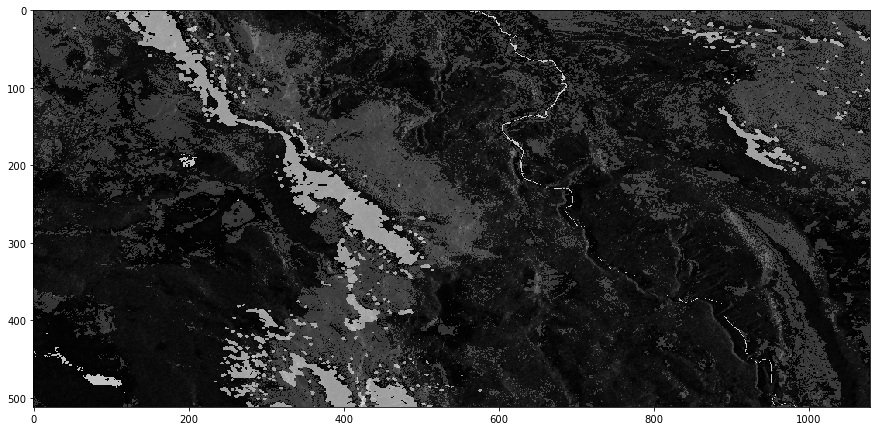

In [13]:
grid = 0.25 * grid1 + 0.75 * grid2
npmin = np.min(grid)
grid = grid - npmin
npmax = np.max(grid)
grid = grid / npmax

plt.figure(figsize=(15, 15))
plt.imshow(grid, cmap='gray')
plt.show()